# Neural Networks Learning

# Introduction

The backpropagation algorithm will be implemented for neural networks and it will be applied to the task of hand-written digit recognition.

# Neural Networks

The backpropagation algorithm will be implemented to learn the parameters for the neural network.

## Visualizing the Data

Load the data and display it on a 2-dimensional plot by calling the function `displayData`.

There are 5000 training examples in `ex3data1.mat`, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each of these training examples becomes a single row in the data matrix $X$. This gives a 5000 by 400 matrix $X$ where every row is a training example for a handwritten digit image.

$$X=\begin{bmatrix}
    -(x^{(1)})^T-\\
    -(x^{(2)})^T-\\
    \vdots\\
    -(x^{(m)})^T-
\end{bmatrix}$$

The second part of the training set is a 5000-dimensional vector $y$ that contains labels for the training set. To make things more compatible with Octave/MATLAB indexing, where there is no zero index, the digit zero has been mapped to the value ten. Therefore, a “0” digit is labeled as “10”, while the digits “1” to “9” are labeled as “1” to “9” in their natural order.

(5000, 400) (5000, 1)


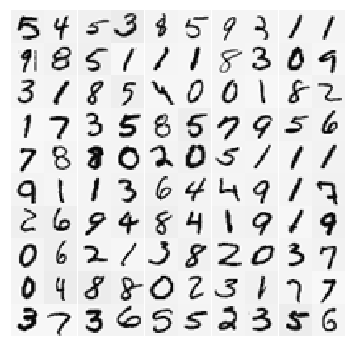

In [1]:
import numpy as np 
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline

data = loadmat('ex3data1.mat')
X = data['X']
y = data['y']

print(X.shape, y.shape)

def displayData(X):
    """
    Select randomly 100 rows from X,
    plot them as 20x20 pixel grayscale images,
    and combine them to one figure with all
    100 digits.
    """
    # Create 100 subplots and remove the gaps
    # between the subplots with gridspec.
    fig, axarr = plt.subplots(10, 10,
                             figsize=(6, 6),
                             gridspec_kw={'wspace':0,
                                          'hspace':0})
    for i in range(10):
        for j in range(10):
            # Select random indices.
            idx = np.random.choice(len(X), 1)
            # Index the array X with the indices.
            pixels = X[idx] # shape(1, 400)
            pixels = pixels.reshape(-1, 20) # shape(20, 20)
            axarr[i,j].imshow(pixels.T, cmap='gray_r')
            # Remove ticks.
            axarr[i,j].set_xticks([])
            axarr[i,j].set_yticks([])
            # Turn off axes.
            axarr[i,j].axis('off')
    plt.show()

displayData(X)

## Model Representation

The neural network has 3 layers - an input layer, a hidden layer and an output layer. Recall that the inputs are pixel values of digit images. Since the images are of size $20x20$, this gives 400 input layer units (not counting the extra bias unit which always outputs +1). The training data will be loaded into the variables $X$ and $y$.

A set of already trained network parameters $(\Theta^{(1)}, \Theta^{(2)})$ stored in `ex3weights.mat` will be loaded by `loadmat` into `Theta1` and `Theta2`. The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).

In [2]:
# Initialize the parameters.
# 20x20 Input images of digits
input_layer_size  = 400

# 25 Hidden units
hidden_layer_size = 25

# 10 Labels, from 1 to 10
# Note that "0" has been mapped to "10".
num_labels = 10

# Load the weights into variables Theta1 and Theta2.
weights = loadmat('ex3weights.mat')
Theta1 = weights['Theta1']
Theta2 = weights['Theta2']

# Create a list of my Thetas.
Thetas = [Theta1, Theta2]

# Unroll parameters and then merge/concatenate.
unrolled_Thetas = [Thetas[i].ravel() for i,_ in enumerate(Thetas)]
nn_params = np.concatenate(unrolled_Thetas)

print("Shape of Theta1: ", Theta1.shape)
print("Shape of Theta2: ", Theta2.shape)
print("Shape of nn_params: ", nn_params.shape)

Shape of Theta1:  (25, 401)
Shape of Theta2:  (10, 26)
Shape of nn_params:  (10285,)


Figure 1 depicts a simple neural network with 3 layers. The first input layer has three units, the input units $x_i$ and is expressed as:

$$x=\alpha^{(1)}=(\alpha_1^{(1)},\alpha_2^{(1)},\alpha_3^{(1)})^T$$

The second hidden layer is similarly:

$$\alpha^{(2)}=(\alpha_1^{(2)},\alpha_2^{(2)},\alpha_3^{(2)})^T$$

where

$$\alpha_1^{(2)}=g(\Theta_{11}^{(1)}\alpha_1^{(1)}+\Theta_{12}^{(1)}\alpha_2^{(1)}+\Theta_{13}^{(1)}\alpha_3^{(1)})$$
$$\alpha_2^{(2)}=g(\Theta_{21}^{(1)}\alpha_1^{(1)}+\Theta_{22}^{(1)}\alpha_2^{(1)}+\Theta_{23}^{(1)}\alpha_3^{(1)})$$
$$\alpha_3^{(2)}=g(\Theta_{31}^{(1)}\alpha_1^{(1)}+\Theta_{32}^{(1)}\alpha_2^{(1)}+\Theta_{33}^{(1)}\alpha_3^{(1)})$$

and $g(z) = \frac{1}{1 + e^{-z}}$ is the logistic function.


The third output layer has only one unit, which returns the hypothesis function:

$$h_{\Theta}(x)=\alpha^{(3)}=(\alpha_1^{(3)})=g(\Theta_{11}^{(2)}\alpha_1^{(2)}+\Theta_{12}^{(2)}\alpha_2^{(2)}+\Theta_{13}^{(2)}\alpha_3^{(2)})$$

![Figure 1](simple_nn.png "Neural Network Model")

## Feedforward and Cost Function

First the cost function and gradient for the neural network will be implemented. Create a `nnCostFunction` fuction to return the cost. Recall that the cost function for the neural network (without regularization) is

$$J(\theta)=\frac{1}{m}\sum_{i=1}^m\sum_{k=1}^K[-y_k^{(i)}log((h_\theta(x^{(i)})_k)-(1-y_k^{(i)})log((1-h_\theta (x^{(i)}))_k)]$$

Note that $h_{\theta}(x^{(i)})_k=\alpha_k^{(3)}$ is the activation (output value) of the $k^{th}$ output unit. Also, recall that whereas the original labels (in the variable $y$) were 1, 2, ..., 10, for the purpose of training a neural network, the labels should be recoded as vectors containing only values 0 or 1, so that

$$y=\begin{bmatrix}
    1\\
    0\\
    0\\
    \vdots\\
    0\\
\end{bmatrix},\hspace{0.5cm}y=\begin{bmatrix}
    0\\
    1\\
    0\\
    \vdots\\
    0\\
\end{bmatrix},...\hspace{0.5cm}or\hspace{0.5cm}
y=\begin{bmatrix}
    0\\
    0\\
    0\\
    \vdots\\
    1\\
\end{bmatrix}$$

For example, if $x^{(i)}$ is an image of the digit 5, then the corresponding $y^{(i)}$ should be a 10-dimensional vector with $y_5=1$, and the other elements equal to 0.

The feedforward computation that computes $h_{\theta}(x^{(i)})$ should be implemented for every example $i$ and the cost over all examples should be summed. The code should also work for a dataset of any size, with any number of labels assuming that there are always at least $K≥3$ labels.

** Note **

The matrix $X$ contains the examples in rows (i.e., $X(i,:)$' is the i-th training example $x^{(i)}$, expressed as a $nx1$ vector). To complete the code in `nnCostFunction` function, we need to add the column of $1$'s to the $X$ matrix. The parameters for each unit in the neural network are represented in `Theta1` and `Theta2` as one row. Speciffically, the first row of Theta1 corresponds to the first hidden unit in the second layer. We can use a for-loop over the examples to compute the cost.

## Regularized Cost Function

For neural networks, the cost function with regularization is going to be slightly more complicated:

$$J(\theta)=\frac{1}{m}\sum_{i=1}^m\sum_{k=1}^K[-y_k^{(i)}log((h_\theta(x^{(i)})_k)-(1-y_k^{(i)})log((1-h_\theta (x^{(i)}))_k)]+\frac{\lambda}{2m}\sum_{l=1}^{L-1}\sum_{i=1}^{s_l}\sum_{j=1}^{s_{l+1}}(\Theta_{j,i}^{(1)})^2$$

For the particular neural network with the 3 layers, the cost function is given by

$$J(\theta)=\frac{1}{m}\sum_{i=1}^m\sum_{k=1}^K[-y_k^{(i)}log((h_\theta(x^{(i)})_k)-(1-y_k^{(i)})log((1-h_\theta (x^{(i)}))_k)]+\frac{\lambda}{2m}[\sum_{j=1}^{25}\sum_{k=1}^{400}(\Theta_{j,k}^{(1)})^2+\sum_{j=1}^{10}\sum_{k=1}^{25}(\Theta_{j,k}^{(2)})^2]$$

We can assume that the neural network will only have 3 layers - an input layer, a hidden layer and an output layer. However, the code can work for any number of input units, hidden units and outputs units. While we have explicitly listed the indices above for $\Theta^{(1)}$ and $\Theta^{(2)}$ for clarity, do note that **the code can in general work with $\Theta^{(1)}$ and $\Theta^{(2)}$ of any size.**

Note that we should not be regularizing the terms that correspond to the bias. For the matrices `Theta1` and `Theta2`, this corresponds to the first column of each matrix. Calling `nnCostFunction` using the loaded set of parameters for `Theta1` and `Theta2`, and $\lambda=1$ we should see that the cost is about 0.383770.

# Backpropagation

To implement the backpropagation algorithm we have to compute the gradient for the neural network cost function. We need to complete the `nnCostFunction` so that it returns an appropriate value for grad. Once we have computed the gradient, we will be able to train the neural network by minimizing the cost function $J(\Theta)$ using an advanced optimizer from `scipy` such as the `minimize` function.

## Sigmoid Gradient

Before the implementation of backpropagation, we need first to implement the sigmoid gradient function. The gradient for the sigmoid function can be computed as

$$g'(z)=\frac{d}{dz}g(z)=g(z)(1-g(z))$$

where

$$sigmoid(z)=g(z)=\frac{1}{1+e^{-z}}$$

When we are done, we can try testing a few values by calling `sigmoidGradient(z)`. For large values (both positive and negative) of $z$, the gradient should be close to $0$. When $z=0$, the gradient should be exactly $0.25$. The code can also work with vectors and matrices. For a matrix, the function can perform the sigmoid gradient function on every element.

## Random Initialization

When training neural networks, it is important to randomly initialize the parameters for symmetry breaking. One effective strategy for random initialization is to randomly select values for $\Theta^{(l)}$ uniformly in the range $[-\epsilon_{init},\epsilon_{init}]$.

We should use $\epsilon_{init}=0.12$. This range of values ensures that the parameters are kept small and makes the learning more efficient. We need to implement a function `randInitializeWeights` that will initialize the weights for $\Theta$.

**Note** One effective strategy for choosing $\epsilon_{init}$ is to base it on the number of units in the network. A good choice of $\epsilon_{init}$ is

$$\epsilon_{init}=\frac{\sqrt{6}}{\sqrt{L_{in}+L_{out}}}$$

where $L_{in}=s_l$ and $L_{out}=s_{l}+1$ are the number of units in the layers adjacent to $\Theta^{(l)}$.

## Backpropagation

Now, we can implement the backpropagation algorithm. Recall that the intuition behind the backpropagation algorithm is as follows. Given a training example $(x^{(t)},y^{(t)})$, we will first run a "forward pass" to compute all the activations throughout the network, including the output value of the hypothesis $h_{\theta}(x)$. Then, for each node $j$ in layer $l$, we would like to compute an "error term" $\delta_j^{(l)}$ that measures how much that node was "responsible" for any errors in our output.

For an output node, we can directly measure the difference between the network's activation and the true target value, and use that to define $\delta_j^{(3)}$ (since layer $3$ is the output layer). For the hidden units, we will compute $\delta_j^{(l)}$ based on a weighted average of the error terms of the nodes in layer $(l+1)$.

In detail, the backpropagation algorithm is shown in Figure 2. To accomplish this we have to implement steps 1 to 4 in a loop that processes one example at a time. Concretely, we should implement a `for-loop` for $t=1:m$ and place steps 1-4 below inside the for-loop, with the $t^{th}$ iteration performing the calculation on the $t^{th}$ training example $(x^{(t)},y^{(t)})$. Step 5 will divide the accumulated gradients by $m$ to obtain the gradients for the neural network cost function.

![Figure 2](backprop.png "Backpropagation Algorithm")

1. Set the input layer's values $(a^{(1)})$ to the $t^{th}$ training example $x^{(t)}$. Perform a feedforward pass (see Figure 3), computing the activations $(z^{(2)},\alpha^{(2)},z^{(3)}, \alpha^{(3)})$ for layers $2$ and $3$. Note that we need to add a $+1$ term to ensure that the vectors of activations for layers $\alpha^{(1)}$ and $\alpha^{(2)}$ also include the bias unit. ![Figure 3](nnModel.png "Feedforward Pass")

2. For each output unit $k$ in layer $3$ (the output layer), set $$\delta_k^{(3)}=(\alpha_k^{(3)}-y_k)$$ where $y_k\in{\{0,1\}}$ indicates whether the current training example belongs to class $k(y_k=1)$, or if it belongs to a different class $(y_k=0)$.

3. For the hidden layer $l=2$, set $$\delta^{(2)}=(\Theta^{(2)})^T\delta^{(3)}.*g'(z^{(2)})$$ Intuitively, $\delta_j^{(l)}$ is the "error" for $\alpha_j^{(l)}$ (unit $j$ in layer $l$). More formally, the delta values are actually the derivative of the cost function, $\delta_j^{(l)}=\frac{\partial}{\partial{z_j^{(l)}}}cost(t)$. Recall that our derivative is the slope of a line tangent to the cost function, so the steeper the slope the more incorrect we are.

4. Accumulate the gradient from this example using the following formula. Note that we should skip or remove $\delta_0^{(2)}$. $$\Delta^{(l)}=\Delta^{(l)}+\delta^{(l+1)}(\alpha^{(l)})^T$$

5. Obtain the gradient for the neural network (with regularization) cost function by dividing the accumulated gradients by $\frac{1}{m}$: $$\frac{\partial}{\partial{\Theta_{ij}^{(l)}}}J(\Theta)=D_{ij}^{(l)}=\frac{1}{m}\Delta_{ij}^{(l)}\hspace{20pt}for\hspace{20pt}j=0$$ $$\frac{\partial}{\partial{\Theta_{ij}^{(l)}}}J(\Theta)=D_{ij}^{(l)}=\frac{1}{m}\Delta_{ij}^{(l)}+\frac{\lambda}{m}\Theta_{ij}^{(l)}\hspace{20pt}for\hspace{20pt}j\geq1$$ Note that we should not be regularizing the first column of $\Theta^{(l)}$ which is used for the bias term. Furthermore, in the parameters $\Theta_{ij}^{(l)}$, $i$ is indexed starting from $1$, and $j$ is indexed starting from $0$. Thus, $$\Theta^{(1)}=\begin{bmatrix}\Theta_{1,0}^{(i)}&\Theta_{1,1}^{(l)}&\dots\\\Theta_{2,0}^{(i)}&\Theta_{2,1}^{(l)}&\dots\\\vdots&\vdots&\ddots\\\end{bmatrix}$$

After we have implemented the backpropagation algorithm, we should implement gradient checking. The gradient checking will allow us to increase our confidence that our code is computing the gradients correctly. If the code is correct, we should expect to see a relative difference that is less than `1e-9`.

### Summarizing the Algorithms

In general, the vectorized algorithms to be applied are:

**Forward Propagation**

1. $\alpha^{(1)}=x$
2. $\text{for }l=1,...,L-1:$
3. $\quad z^{(l+1)}=\Theta^{(l)}a^{(l)}$
4. $\quad \alpha^{(l+1)}=g(z^{(l+1)})$
5. $\text{end}$
6. $h_{\Theta}(x)=\alpha^{(L)}$

**Back Propagation**

1. $\delta^{(L)}=a^{(L)}-y$
2. $\text{for } l= L-1,...,2:$
3. $\quad \delta^{(l)}=(\Theta^{(l)})^T\delta^{(l + 1)}.*g'(z^{(l)})$
4. $\text{end}$

**Algorithm for the gradient of $J(\Theta)$**

1. $\text{Set } \Delta^{(l)}:=0, \text{ for } l=1, ..., L-1$
2. $\text{For training example } t=1, ..., m:$
3. $\quad \text{Set } \alpha^{(1)}=x^{(t)}$
4. $\quad \text{Perform forward propagation to compute } \alpha^{(l)} \text{ for } l=1,...,L$
5. $\quad \text{Using } y^{(t)}, \text{ compute } \delta^{(L)}=\alpha^{(L)}-y^{(t)}$
6. $\quad \text{Perform back propagation computing } \delta^{(L-1)},\delta^{(L-2)},...,\delta^{(2)} \text{ using } \delta^{(l)}=(\Theta^{(l)})^T\delta^{(l + 1)}.*g'(z^{(l)}) \text{ where } g'(z^{(l)})=\alpha^{(l)}.*(1-\alpha^{(l)})$
6. $\quad \Delta^{(l)}:=\Delta^{(l)}+\delta^{(l+1)}(a^{(l)})^T \text{ for } l=L-1, ..., 1$
7. $\text{end}$

Hence we update our new $\Delta$ matrix.

$D_{ij}^{(l)}:=\frac{1}{m}\Delta_{ij}^{(l)}\text{ for }j=0$

$D_{ij}^{(l)}:=\frac{1}{m}(\Delta_{ij}^{(l)}+\lambda \Theta_{ij}^{(l)})\text{ for }j\geq1$

The capital-delta matrix $D$ is used as an "accumulator" to add up our values as we go along and eventually compute our partial derivative, $\frac{\partial}{\partial{\Theta_{ij}^{(l)}}}J(\Theta)=D_{ij}^{(l)}$.

In [3]:
# Create the logistic sigmoid function.
def sigmoid(z):
    """
    Computes the sigmoid function.
    Args:
        z: float, vector, matrix
    Returns:
        sigmoid: float, vector, matrix
    """
    sigmoid = 1 / (1 + np.exp(-z))
    return sigmoid

# Create the sigmoid gradient function.
def sigmoidGradient(z):
    """
    Computes the gradient of the sigmoid function
    evaluated at z. This works regardless if z is
    a matrix or a vector. In particular, if z is
    a vector or matrix, it returns the gradient for
    each element.
    Args:
        z: float, vector, matrix
    Returns:
        g_prime: float, vector, matrix
    """
    g_prime = sigmoid(z) * (1 - sigmoid(z))
    return g_prime

# Create the neural network cost function.
def nnCostFunction(nn_params,
                   input_layer_size,
                   hidden_layer_size,
                   num_labels,
                   X, y, lambda_coef):
    """
    Implements the neural network cost function for a two layer
    neural network which performs classification.
    Computes the cost and gradient of the neural network. The
    parameters for the neural network are "unrolled" into the vector
    nn_params and are converted back into the weight matrices.
    The returned parameter grad is an "unrolled" vector of the
    partial derivatives of the neural network.
    Args:
        nn_params: vector array
        input_layer_size: int
        hidden_layer_size: int
        num_labels: int
        X: array (m, input_layer_size)
        y: array (m, num_labels)
        lambda_coef: int
    Returns:
        J: float
        grad: vector array
    """
    # Reshape nn_params back into the parameters Theta1 and Theta2,
    # the weight matrices for our 2 layer neural network.
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, input_layer_size + 1)) # (25,401)
    Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):],
                        (num_labels, hidden_layer_size + 1)) # (10,26)

    # Get the number of training examples, m.
    m = X.shape[0]
    
    # Insert a 1's column for the bias unit.
    X = np.insert(X, 0, 1, axis=1) # (5000,401)
    
    # Perform forward propagation to compute a(l) for l=1,...,L.
    # z(l+1) = theta(l)a(l) and a(l+1) = g(z(l+1)).
    z2 = np.dot(X, Theta1.T) # (5000, 25)
    a2 = sigmoid(z2) # (5000, 25)
    
    # Add 1's for the bias unit.
    a2 = np.insert(a2, 0, 1, axis=1) # (5000,26)
    z3 = np.dot(a2, Theta2.T) # (5000, 10)
    a3 = sigmoid(z3) # (5000, 10)
    
    # Create a y matrix of shape (m, K)
    # for later use in recoding.
    y_recoded = np.zeros((m, num_labels)) # (5000, 10)
    
    # Initialize Delta matrices.
    D1 = np.zeros((hidden_layer_size, input_layer_size + 1)) # (25,401)
    D2 = np.zeros((num_labels, hidden_layer_size + 1)) # (10,26)
    
    #############################################################
    ########## Forward Propagation and Cost Computation #########
    #############################################################
    
    # Initialize cost.
    j = 0
    # Fwd pass; for training example t = 1,...,m:
    for t in range(m):
        x_t = X[t]
        
        # Recode the categorical integer values of  y
        # as vectors with all values set to zeros except
        # for one value set to "1", which indicates whether
        # it belongs to class k (yk = 1).
        y_recoded[t, y[t] - 1] = 1
            
        # Compute cost for every training example.
        j += np.sum(-y_recoded[t] * np.log(a3[t]) - (1 - y_recoded[t]) * np.log(1 - a3[t])) # float

        ###############################################################
        ########## Back Propagation and Gradients Computation #########
        ###############################################################
    
        # Compute the error delta.
        d_3 = a3[t] - y_recoded[t] # (10,)
        d_3 = d_3.reshape(-1,1) # (10,1)
        
        # Perform back propagation.
        # In the parameters Thetas_i,j, i are indexed
        # starting from 1, and j is indexed starting from  0.
        d_2 = np.dot(Theta2.T[1:,:], d_3) * sigmoidGradient(z2[t].reshape(-1,1)) # (25,10)x(10,1).*(25,1) = (25,1)
        D1 += np.dot(d_2, x_t.reshape(-1, 1).T) # (25,401)
        D2 += np.dot(d_3, a2[t].reshape(1,-1)) # (10,26)

    # Compute total cost.
    J = j / m # float
    
    # Compute the regularization term.
    # We should not be regularizing the first column of theta,
    # which is used for the bias term.
    Theta1_sum = np.sum(np.square(Theta1[:,1:])) # float
    Theta2_sum = np.sum(np.square(Theta2[:,1:])) # float
    reg_term = Theta1_sum + Theta2_sum # float
    
    # Compute total cost with regularization.
    J = J + (lambda_coef / (2 * m)) * reg_term # float
    
    # Update our new Delta matrices with regularization.
    # We should not be regularizing the first column of theta,
    # which is used for the bias term.
    # First devide every value in Deltas with m.
    D1 = D1 / m
    D2 = D2 / m
    D1[:,1:] = D1[:,1:] + (lambda_coef / m) * Theta1[:,1:]
    D2[:,1:] = D2[:,1:] + (lambda_coef / m) * Theta2[:,1:]
    
    # Unroll gradients.
    Deltas = [D1, D2]
    unrolled_Deltas = [Deltas[i].ravel() for i,_ in enumerate(Deltas)]
    grad = np.concatenate(unrolled_Deltas)

    return J, grad

# Create the randomly weights-initialization function.
def randInitializeWeights(L_in, L_out):
    """
    Randomly initialize the weights of a layer with L_in
    incoming connections and L_out outgoing connections.
    Note that the column row of W handles the "bias" terms.
    Args:
        L_in: int
        L_out: int
    Returns:
        W: array (L_out, 1 + L_in)
    """
    # Set the range epsilon.
    epsilon_init = 0.12
    
    # Initialize the W matrix.
    W = np.zeros((L_out, 1 + L_in))
    
    # Produce the random values in the range [-epsilon, epsilon].
    W = np.random.rand(L_out, 1 + L_in) * (2 * epsilon_init) - epsilon_init
    return W

nnCostFunction(nn_params,
                   input_layer_size,
                   hidden_layer_size,
                   num_labels,
                   X, y, 1)

(0.38376985909092348,
 array([  6.18712766e-05,  -2.11248326e-12,   4.38829369e-13, ...,
          4.70513145e-05,  -5.01718610e-04,   5.07825789e-04]))

## Gradient Checking

In our neural network, we are minimizing the cost function $J(\Theta)$. To perform gradient checking on our parameters, we can imagine “unrolling” the parameters $\Theta^{(1)}$, $\Theta^{(2)}$ into a long vector $\theta$. By doing so, we can think of the cost function being $J(\theta)$ instead and use the following gradient checking procedure.

Suppose we have a function $f_i(\theta)$ that purportedly computes $\frac{\partial}{\partial{\theta_i}}J(\theta)$; We would like to check if $f_i$ is outputting correct derivative values.

$$Let\hspace{10pt}\theta^{(i+)}=\theta+\begin{bmatrix}
    0\\
    0\\
    \vdots\\
    \epsilon\\
    \vdots\\
    0\\
\end{bmatrix}\hspace{10pt}and\hspace{10pt}\theta^{(i-)}=\theta-\begin{bmatrix}
    0\\
    0\\
    \vdots\\
    \epsilon\\
    \vdots\\
    0\\\end{bmatrix}$$

So, $\theta^{(i+)}$ is the same as $\theta$, except its $i^{th}$ element has been incremented by $\epsilon$. Similarly, $\theta^{(i-)}$ is the corresponding vector with the $i^{th}$ element decreased by $\epsilon$. We can now numerically verify $f_i(\theta)$’s correctness by checking, for each $i$, that:

$$f_i(\theta)\approx\frac{J(\theta^{(i+)})-J(\theta^{(i-)})}{2\epsilon}$$

The degree to which these two values should approximate each other will depend on the details of $J$. But assuming $\epsilon=10^{−4}$, we’ll usually find that the left- and right-hand sides of the above will agree to at least 4 significant digits (and often many more).

The implementation of the computation of the numerical gradient is achieved with the `computeNumericalGradient` function.

Next, we can run the function `checkNNGradients` which will create a small neural network and dataset that will be used for checking our gradients. If the backpropagation implementation is correct, we should see a relative difference that is less than $10^{-9}$.

**Tips:**

1. When performing gradient checking, it is much more efficient to use a small neural network with a relatively small number of input units and hidden units, thus having a relatively small number of parameters. Each dimension of $\theta$ requires two evaluations of the cost function and this can be expensive. In the function `checkNNGradients`, our code creates a small random model and dataset which is used with `computeNumericalGradient` for gradient checking. Furthermore, after we are confident that our gradient computations are correct, we should turn off gradient checking before running our learning algorithm.

2. Gradient checking works for any function where we are computing the cost and the gradient. Concretely, we can use the same `computeNumericalGradient` function to check if our gradient implementations for the other cases are correct too, e.g. logistic regression’s cost function.

In [4]:
def debugInitializeWeights(fan_out, fan_in):
    """
    Initialize the weights of a layer with fan_in
    incoming connections and fan_out outgoing
    connections using a fix set of values. This will
    help us in debugging.
    Note that W should be set to a matrix of size
    (1 + fan_in, fan_out) as the first row of W
    handles the "bias" terms.
    Args:
        fan_in: int
        fan_out: int
    Returns:
        W: array (fan_out, 1 + fan_in)
    """
    # Initialize the W matrix.
    W = np.zeros((fan_out, 1 + fan_in))
    
    # The "sin" function ensures that W is always of
    # the same values and will be useful for debugging.
    W = np.reshape(np.sin(range(W.size)), W.shape) / 10
    
    return W

def computeNumericalGradient(J, theta):
    """
    Computes the numerical gradient of the function J
    around theta using "finite differences" and gives
    a numerical estimate of the gradient.
    Notes: The following code implements numerical
           gradient checking, and returns the numerical
           gradient. It sets numgrad(i) to (a numerical 
           approximation of) the partial derivative of J
           with respect to the i-th input argument,
           evaluated at theta. (i.e., numgrad(i) should
           be the (approximately) the partial derivative
           of J with respect to theta(i).)
    Args:
        J: function
        theta: vector array
    Returns:
        numgrad: vector array
    """
    # Initialize parameters.
    numgrad = np.zeros(theta.shape)
    perturb = np.zeros(theta.shape)
    e = 1e-4

    for p in range(theta.size):
        # Set the perturbation vector.
        perturb.reshape(perturb.size)[p] = e
        loss1, _ = J(theta - perturb)
        loss2, _ = J(theta + perturb)
        # Compute the Numerical Gradient.
        numgrad.reshape(numgrad.size)[p] = (loss2 - loss1) / (2 * e)
        perturb.reshape(perturb.size)[p] = 0
        
    return numgrad

def checkNNGradients(lambda_coef):
    """
    Creates a small neural network to check the
    backpropagation gradients. It will output the
    analytical gradients produced by the backprop
    code and the numerical gradients (computed
    using computeNumericalGradient). These two
    gradient computations should result in very
    similar values.
    Args:
        lambda_coef: int
    """
    # Initialize a small network.
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5

    # Generate some 'random' test data.
    Theta1 = debugInitializeWeights(hidden_layer_size, input_layer_size)
    Theta2 = debugInitializeWeights(num_labels, hidden_layer_size)
    
    # Reuse debugInitializeWeights to generate X.
    X  = debugInitializeWeights(m, input_layer_size - 1)
    # np.mod returns element-wise remainder of division.
    y  = 1 + np.mod(range(m), num_labels).T

    # Unroll parameters.
    Thetas = [Theta1, Theta2]
    unrolled_Thetas = [Thetas[i].ravel() for i,_ in enumerate(Thetas)]
    nn_params = np.concatenate(unrolled_Thetas)

    # Create short hand for cost function.
    def costFunc(p):
        return nnCostFunction(p, input_layer_size, hidden_layer_size,
                              num_labels, X, y, lambda_coef)

    _, grad = costFunc(nn_params)
    numgrad = computeNumericalGradient(costFunc, nn_params)

    # Visually examine the two gradient computations.
    # The two columns should be very similar. 
    for numerical, analytical in zip(numgrad, grad):
        print('Numerical Gradient: {0:10f}, Analytical Gradient {1:10f}'.format(numerical, analytical))
    print('\nThe above two columns should be very similar.')

    # Evaluate the norm of the difference between two solutions.  
    # If we have a correct implementation, and assuming we used e = 0.0001 
    # in computeNumericalGradient, then diff below should be less than 1e-9.
    diff = np.linalg.norm(numgrad-grad) / np.linalg.norm(numgrad+grad)

    print('If the backpropagation implementation is correct, then \n' \
             'the relative difference will be small (less than 1e-9). \n' \
             '\nRelative Difference: {:.10E}'.format(diff))

checkNNGradients(0)

Numerical Gradient:   0.006907, Analytical Gradient   0.006907
Numerical Gradient:  -0.000111, Analytical Gradient  -0.000111
Numerical Gradient:   0.000144, Analytical Gradient   0.000144
Numerical Gradient:   0.000266, Analytical Gradient   0.000266
Numerical Gradient:   0.012125, Analytical Gradient   0.012125
Numerical Gradient:  -0.000043, Analytical Gradient  -0.000043
Numerical Gradient:   0.000152, Analytical Gradient   0.000152
Numerical Gradient:   0.000207, Analytical Gradient   0.000207
Numerical Gradient:   0.006198, Analytical Gradient   0.006198
Numerical Gradient:   0.000064, Analytical Gradient   0.000064
Numerical Gradient:   0.000020, Analytical Gradient   0.000020
Numerical Gradient:  -0.000042, Analytical Gradient  -0.000042
Numerical Gradient:  -0.005424, Analytical Gradient  -0.005424
Numerical Gradient:   0.000113, Analytical Gradient   0.000113
Numerical Gradient:  -0.000130, Analytical Gradient  -0.000130
Numerical Gradient:  -0.000253, Analytical Gradient  -0

## Learning Parameters

After we have successfully implemented the neural network cost function and gradient computation, the next step is to use an optimization function such as `minimize` to learn a good set parameters.

After the training completes, we can proceed to report the training accuracy of our classifier by computing the percentage of examples it got correct. If our implementation is correct, we should see a reported training accuracy of about $95\%$ (this may vary by about $1%$ due to the random initialization). It is possible to get higher training accuracies by training the neural network for more iterations. We can try training the neural network for more iterations (e.g., set `MaxIter` to `400`) and also vary the regularization parameter $\lambda$. With the right learning settings, it is possible to get the neural network to perfectly fit the training set.

In [5]:
from scipy.optimize import minimize

# Create a cost function optimizer.
def optimizeCost(maxiter, lambda_coef):
    """
    Optimizes the Cost Function.
    Args:
        maxiter: int
        lambda_coef: float
    Returns:
        thetas: vector array
    """
    ##########################################
    ########## Initialize nn_params ##########
    ##########################################
    Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
    Theta2 = randInitializeWeights(hidden_layer_size, num_labels)
    # Unroll parameters.
    Thetas = [Theta1, Theta2]
    unrolled_Thetas = [Thetas[i].ravel() for i,_ in enumerate(Thetas)]
    nn_params = np.concatenate(unrolled_Thetas)
    
    ##########################################
    ##########       Optimize       ##########
    ##########################################
    # Optimize the cost function.
    results = minimize(fun=nnCostFunction,
                       x0=nn_params,
                       args=(input_layer_size,
                             hidden_layer_size,
                             num_labels,
                             X, y, lambda_coef),
                       method='CG',
                       jac=True,
                       options={'maxiter':maxiter, 'disp': True})
    thetas = results.x

    return thetas

# Train the neural network for 40 iterations.
# Set regularization parameter to 1.
nn_params = optimizeCost(40, 1)

         Current function value: 0.490673
         Iterations: 40
         Function evaluations: 84
         Gradient evaluations: 84


In [6]:
# Create the prediction function
def predict(Theta1, Theta2, X):
    """
    Predicts the label of an input X
    given the trained weights of a
    neural network (Theta1, Theta2).
    Args:
        Theta1: array (hidden_layer_size, 1 + input_layer_size)
        Theta2: array (num_labels, 1 + hidden_layer_size)
        X: array (m, input_layer_size)
    Returns:
        p_argmax: vector array (m,)
    """
    # Get some useful values.
    m = len(X)
    num_labels = len(Theta2)
    
    # Initialize prediction p.
    p = np.zeros((m, 1))
    
    #Insert a 1's column to X.
    X = np.insert(X, 0, 1, axis=1)
    a2 = sigmoid(np.dot(X, Theta1.T))
    #Insert a 1's column to a2.
    a2 = np.insert(a2, 0, 1, axis=1)
    h_theta = sigmoid(np.dot(a2, Theta2.T))
    p_argmax = np.argmax(h_theta, axis=1)
    # Add 1 to fix for Python's zero indexed array.
    p_argmax = p_argmax + 1
    
    return p_argmax

# Create a function to output the accuracy score.
def outputAccuracy(nn_params):
    """
    Outputs the accuracy of the
    trained neural network.
    Args:
        nn_params: vector array
    """
    # After the training of the neural network, reshape
    # nn_params back into the parameters Theta1 and Theta2,
    # the weight matrices for our 2 layer neural network.
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, input_layer_size + 1))
    Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):],
                        (num_labels, hidden_layer_size + 1))

    predictions = predict(Theta1, Theta2, X)
    print('\nTraining Set Accuracy: {0:.2f}%'.format(100 * np.mean(predictions == y.reshape(-1))))

outputAccuracy(nn_params)


Training Set Accuracy: 94.80%


# Visualizing the Hidden Layer

One way to understand what our neural network is learning is to visualize what the representations captured by the hidden units. Informally, given a particular hidden unit, one way to visualize what it computes is to find an input $x$ that will cause it to activate (that is, to have an activation value $(\alpha^{(l)})$ close to $1$). For the neural network we trained, notice that the $i^{th}$ row of $\Theta^{(1)}$ is a 401-dimensional vector that represents the parameter for the $i^{th}$ hidden unit. If we discard the bias term, we get a 400-dimensional vector that represents the weights from each input pixel to the hidden unit.

Thus, one way to visualize the “representation” captured by the hidden unit is to reshape this 400-dimensional vector into a $20x20$ image and display it. This can be done by using the `displayData` function, which will show an image with 25 units, each corresponding to one hidden unit in the network.

In the trained network, it can be found that the hidden units corresponds roughly to detectors that look for strokes and other patterns in the input.

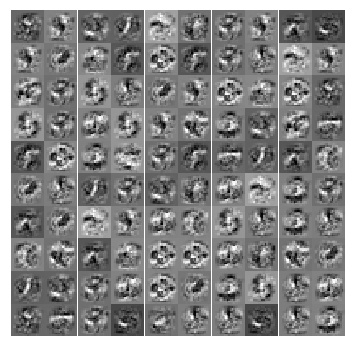

In [7]:
displayData(Theta1[:, 1:])

## Play

We can try out different learning settings for the neural network to see how the performance of the neural network varies with the regularization parameter $\lambda$ and number of training steps (the `MaxIter` option when using `minimize`).

Neural networks are very powerful models that can form highly complex decision boundaries. Without regularization, it is possible for a neural network to “overfit” a training set so that it obtains close to $100\%$ accuracy on the training set but does not as well on new examples that it has not seen before. The regularization $\lambda$ can be set to a smaller value and the `MaxIter` parameter to a higher number of iterations to see this.

The changes in the visualizations of the hidden units can also be depicted when the learning parameters $\lambda$ and `MaxIter` are changed.

In [8]:
# Create different cases of the learning parameters, lambda_coef and MaxIter.
cases = {"MaxIter = 10 and lambda_coef = 0.5": (10, 0.5),
         "MaxIter = 10 and lambda_coef = 100": (10, 100),
         "MaxIter = 10 and lambda_coef = 1000": (10, 1000),
         "MaxIter = 30 and lambda_coef = 1": (30, 1),
         "MaxIter = 200 and lambda_coef = 0": (200, 0)}

for k, v in cases.items():
    print(60 * "-")
    print()
    print(k)
    nn_params = optimizeCost(v[0], v[1])
    outputAccuracy(nn_params)

------------------------------------------------------------

MaxIter = 10 and lambda_coef = 0.5
         Current function value: 1.256776
         Iterations: 10
         Function evaluations: 21
         Gradient evaluations: 21

Training Set Accuracy: 82.74%
------------------------------------------------------------

MaxIter = 10 and lambda_coef = 100
         Current function value: 2.702304
         Iterations: 10
         Function evaluations: 22
         Gradient evaluations: 22

Training Set Accuracy: 73.10%
------------------------------------------------------------

MaxIter = 10 and lambda_coef = 1000
         Current function value: 3.292116
         Iterations: 10
         Function evaluations: 20
         Gradient evaluations: 20

Training Set Accuracy: 10.00%
------------------------------------------------------------

MaxIter = 30 and lambda_coef = 1
         Current function value: 0.674454
         Iterations: 30
         Function evaluations: 63
         Gradient 